In [1]:
import pandas as pd 
import numpy as np 
from scipy.stats import gmean
import matplotlib.pyplot as plt
import cvxpy as cp
import torch.nn
import torch
from cvxpylayers.torch import CvxpyLayer

In [2]:
def remove_negatives(arr):
    return [y if y > 0.01 else 0 for y in arr]

In [3]:
def followers_prob(mu, Q, V, ub):
    # n: number of assets
    # mu: expected returns (nx1)
    # Q: expected covariance (nxn)
    # V: maximum variance
    # ub: upper bound (nx1) 

    n = len(mu)
    x = cp.Variable(n)
    Z = cp.Parameter()

    obj = cp.Maximize(mu.T @ x)
    const = [cp.quad_form(x, Q) <= Z,
                np.ones([1, n]) @ x == 1,
                x >= 0,
                x <= ub]
    prob = cp.Problem(obj, const)
    assert prob.is_dpp()

    cvxpylayer = CvxpyLayer(prob, parameters=[Z], variables=[x])
    
    Z_tch = torch.tensor(V, requires_grad=True)
    solution, = cvxpylayer(Z_tch)

    return solution

In [4]:
def get_lower_upper_var(Q, ub):
    # returns (L, U) for the variance to make it feasible
    K = 0.01 # increase chance of feasibility

    U = -float("inf")

    for index, val in enumerate(ub):
        if val and Q[index][index] > U:
            U = Q[index][index]

    n = len(Q)
    x = cp.Variable(n)

    obj = cp.Minimize(cp.quad_form(x, Q))
    const = [np.ones([1, n]) @ x == 1,
            x >= 0,
            x <= ub]
    
    prob = cp.Problem(obj, const)
    prob.solve(solver=cp.ECOS)
    L = prob.value*(1+K)

    return L, U

In [5]:
def plot_portfolios(portfolio):
    trader = {0: "Financials", 1: "Information Technology", 2: "Consumer Staples"}
    plt.subplots(nrows=1, ncols=4,figsize=(25, 5))

    all_tickers = []
    all_weights = []

    # plot each trader's distribution
    for i in portfolio:
        ax = plt.subplot(1, 4, i+1)
        plt.pie(remove_negatives(portfolio[i].values()), labels=portfolio[i].keys())
        ax.set_title(f"{trader[i]} Trader Distribution")

        all_tickers.extend(portfolio[i].values())
        all_weights.extend(portfolio[i].keys())

    # plot the total firm distribution
    ax = plt.subplot(1, 4, 4)
    plt.pie(remove_negatives(all_tickers), labels=all_weights)
    ax.set_title(f"Firm Distribution")

In [6]:
full_prices = pd.read_csv("../data/Equity_Prices_Full.csv", index_col=0)
full_prices.index = pd.to_datetime(full_prices.index)

sectors = {"Financials": ["ALL", "BAC", "C", "GS", "JPM"],
           "Information Technology": ["AAPL", "INTC", "MSFT", "IBM", "CSCO"],
           "Consumer Staples": ["KO", "COST", "PG", "WMT", "TGT"]}

tickers = np.ndarray.flatten(np.array(list(sectors.values())))
n = len(tickers)

full_prices = full_prices[tickers]

In [7]:
strategies = {} #key is trader ID, value is ub array (1 if allowed to invest)

strategies[0] = [1 if ticker in sectors["Financials"] else 0 for ticker in tickers]
strategies[1] = [1 if ticker in sectors["Information Technology"] else 0 for ticker in tickers]
strategies[2] = [1 if ticker in sectors["Consumer Staples"] else 0 for ticker in tickers]

In [8]:
subset_start_date = "2010-01-01"
subset_date = "2012-12-31"

subset_prices = full_prices.loc[subset_start_date:subset_date]
subset_returns = subset_prices.pct_change(1).iloc[1:, :]

training_returns = subset_returns.iloc[:-1,:]
test_returns = subset_returns.iloc[-1,:]

subset_prices.head()

,ALL,BAC,C,GS,JPM,AAPL,INTC,MSFT,IBM,CSCO,KO,COST,PG,WMT,TGT
Date,,,,,,,,,,,,,,,
2010-01-31,29.93,15.18,3.32,148.72,38.94,192.063,19.40,28.1800,122.39,22.47,54.25,57.43,61.55,53.43,51.27
2010-02-28,31.25,16.66,3.40,156.35,41.97,204.620,20.53,28.6700,127.16,24.33,52.72,60.97,63.28,54.07,51.52
2010-03-31,32.31,17.85,4.05,170.63,44.70,235.000,22.29,29.2875,128.25,26.03,55.00,59.71,63.27,55.60,52.60
2010-04-30,32.67,17.83,4.37,145.20,42.58,261.090,22.84,30.5350,129.00,26.93,53.45,59.08,62.16,53.64,56.87
2010-05-31,30.63,15.74,3.96,144.26,39.58,256.880,21.42,25.8000,125.26,23.16,51.40,58.25,61.09,50.56,54.53


In [9]:
mu = gmean(training_returns + 1) -1
Q = np.cov(training_returns.T)

assert mu.shape == (n,)
assert Q.shape == (n,n)

# check for PSD
assert min(np.linalg.eigvals(Q) > 1e-9)

Initial risk distribution: [0.93796474 0.0052987  0.00539088]
Initial budget distribution: [3333.33333333 3333.33333333 3333.33333333]
Reward: 347.2421220960651
Risk: 0.10446092641660781
L: tensor([1.0186e+09], dtype=torch.float64, requires_grad=True)
None
tensor([1.], dtype=torch.float64)


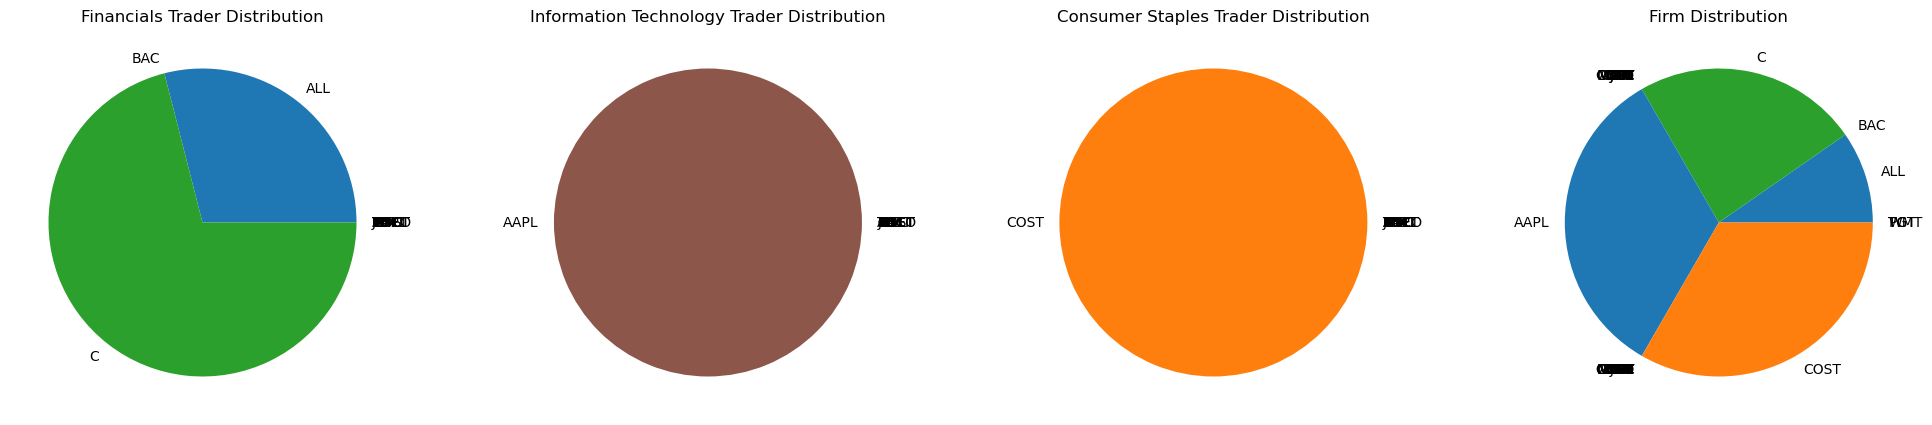

In [10]:
# firm constraints
total_budget = 10000
risk_coeff = 0.05
N = 3


# initialize slack variables
slack_var = np.full(N*3+2, 100)

# initialize decision vars
Z = np.array([])
B = np.full(N, total_budget/N)

# initialize risk range
L, U = [], []
for i in range(N):
    lower, upper = get_lower_upper_var(Q, strategies[i])
    L.append(lower)
    U.append(upper)

    Z = np.append(Z, (upper+lower)/2)

# initialize overall holdings
overall_holdings = np.zeros(n)
portfolio = {}
for i in range(3):
    x = followers_prob(mu, Q, Z[i], strategies[i])
    overall_holdings += (B[i]*x.detach().numpy())

    portfolio[i] = {tickers[index]:weight for index, weight in enumerate(x.detach().numpy()) if weight}
reward = mu.T @ overall_holdings
risk = (overall_holdings @ Q @ overall_holdings)/(sum(B)**2)

print(f"Initial risk distribution: {Z}")
print(f"Initial budget distribution: {B}")
print(f"Reward: {reward}")
print(f"Risk: {risk}")
plot_portfolios(portfolio)

gradient = np.ones([N*3+2])
# gradient size is N*3 + 2
# 1: budget constraint
# N: upper variance constraint
# N: lower variance constraint
# N: budget nonnegative constraint
# 1: risk constraint

gradient[0] = (sum(B) - total_budget)

for i in range(N):
    gradient[i+1] = Z[i] - U[i]

for i in range(N):
    gradient[i+1+N] = -Z[i] + L[i]

for i in range(N):
    gradient[i+1+2*N] = -B[i]

gradient[1+3*N] = overall_holdings @ Q @ overall_holdings - (risk_coeff*total_budget)**2

total_reward =  -mu.T @ overall_holdings
L = torch.tensor([total_reward + slack_var @ gradient], requires_grad=True)

print(f"L: {L}")

print(L.backward())
print(L.grad)